In [1]:
import numpy as np
import scipy as sp
from iminuit import Minuit
import pandas as pd
idx = pd.IndexSlice

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

import clapy

In [2]:
from math import sqrt,log
def fitfunc( t, Tc, r, GF):
    if t<(Tc-Tc*r):
        res = GF/Tc*(t+Tc*r)
    else:
        res =  GF
    return res 

def mypdfln( x,  mu,  std):
    #cpdef means generate both c function and python function
    norm = (sqrt(2*np.pi*std*std))
    ret = (-1*(x-mu)*(x-mu)/(2.*std*std))-log(norm)
    return ret




class Nowakowski_LH:  
    def __init__(self,data,t):
        self.data = data
        self.t = t
        self.ndata = len(data)
    
    def compute(self,  Tc, r, GF, s):
        #this line is a cast not a copy. Let cython knows mydata will spit out double
        mydata = self.data
        myt = self.t
        loglh = 0.
        lmu = 0.
        ler = 0.
        for i in range(self.ndata):
            lmu = fitfunc(myt[i],Tc,r,GF)
            loglh -= mypdfln(mydata[i],lmu,s)
        return loglh


In [3]:
#do not run if latex renderer for matplotlib doesn't work
from matplotlib import rc
rc('text', usetex=True)


In [4]:
#some settings
sizeB = 3.25*1.1
sizeH = 2.5*1.1
fonts = 0.9
color_pr = np.array([0.5647058823529412, 0.9333333333333333, 0.5647058823529412]) - np.array([0.4,0.1,0.4])
color_no = '#CC79A7'

font ='DejaVu Serif'

In [5]:
## default parameters


asym_dist = clapy.dist()

dargs = {
        'samples': 10000,
        'nCells': 100,
        'mCells': 100,
        'GF': 0.95,
        'G1': 0.5,
        'S': 0.3,
        'G2M': 0.2,
        'sCells' : 0.3,
        'sSamples' : 0.2
}

dTC = dargs['G1']+dargs['G2M']+dargs['S']
dFS = dargs['S']/dTC
X = np.arange(0,dargs['nCells']+1)
time_points = np.linspace(0.01,1.965625,22)
measure_times = np.ravel(np.array(time_points)[:,np.newaxis]*np.ones(dargs['samples']))


In [6]:
#load data
npz  = np.load('paper_img_data.npz')
data_asy = npz['data_asy']
data_sym = npz['data_sym']
pdfs = npz['pdfs']
pdfm = npz['pdfm']


------------------------------------------------------------------
| FCN = -13.62                  |     Ncalls=173 (173 total)     |
| EDM = 2.07E-05 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


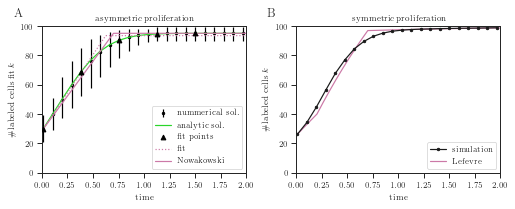

In [18]:
sb.set(context="paper",style='ticks',font=font,font_scale=fonts)

fig = plt.figure(2,figsize=(sizeB*2, sizeH))
fig.clear()
ax2 = plt.subplot2grid((1,2),(0,1))
ax = plt.subplot2grid((1,2),(0,0))

ax.set_ylim((0,100))
ax.set_xlim((0,2))
ax.set_xlabel('time')
ax.set_ylabel('\#labeled cells fit $k$')



#calc mean and cdf for asym
mean_asym = np.array([np.mean(i[0]) for i in data_asy])

error_asy =[]
for i in data_asy:
    x_asy,y_asy = clapy.ecdf(i[0])
    p95a = int(np.round(dargs['samples']*0.025))
    p95e = int(np.round(dargs['samples']*0.975))
    error_asy.append([x_asy[p95a],x_asy[p95e]])
error_asy = np.abs(np.array(error_asy).T - mean_asym)

#fit Nowakowski
lh = Nowakowski_LH(np.array([np.mean(i[0])/dargs['nCells'] for i in data_asy])[:-5:4],time_points[:-5:4])
mi_old = Minuit(lh.compute, Tc=1.0, r=0.3,GF=1,s=0.1,\
                      error_r=0.1,error_GF=0.1,error_Tc=0.1,error_s=0.1,\
           limit_Tc=(0.00001,2), limit_r=(0.00001,1),limit_GF=(0,1),limit_s=(0.0001,1),\
           errordef=0.5,print_level=2)
mi_old.migrad()
res = mi_old.values
args = {
        'GF': res['GF'],
        'G1': res['Tc']*((1-res['r'])*0.5),
        'S': res['Tc']*res['r'],
        'G2M': res['Tc']*((1-res['r'])*0.5)
}



#plot
plt.errorbar(time_points,mean_asym,error_asy,fmt='.',color='black',label="nummerical sol.",zorder=2 )

ttt = np.linspace(0,2,1000)
plt.plot(ttt,dargs['nCells']*clapy.cla_det_model(ttt,mode=1,**dargs),label="Nowakowski",color=color_no,zorder=5)
plt.plot(ttt,dargs['nCells']*clapy.cla_det_model(ttt,**args),':',color=color_no,label="fit",zorder=6)

plt.plot(time_points[:-5:4],[np.mean(i[0]) for i in data_asy][:-5:4],'^',color='black',label="fit points",zorder=7 )

plt.plot(time_points,np.array(pdfm),label='analytic sol.',color=color_pr,zorder=4)




handles, labels = ax.get_legend_handles_labels()
ax.legend(list(reversed(handles)), list(reversed(labels)), loc='lower right')



ax2.set_ylim((0,100))
ax2.set_xlim((0,2))
ax2.set_xlabel('time')
ax2.set_ylabel('\#labeled cells $k$')

#calc mean and cdf for asym
mean_sym = np.array([np.mean(i[0]) for i in data_sym])

error_sym =[]
for i in data_sym:
    x_sym,y_sym = clapy.ecdf(i[0])
    p95a = int(np.round(dargs['samples']*0.025))
    p95e = int(np.round(dargs['samples']*0.975))
    error_sym.append([x_sym[p95a],x_sym[p95e]])
error_sym = np.abs(np.array(error_sym).T - mean_sym)

ax2.plot(ttt,dargs['nCells']*clapy.cla_det_model(ttt,mode=2,**dargs),label="Lefevre",color=color_no,zorder=1)

ax2.plot(time_points,mean_sym,'k.-',label="simulation")


handles, labels = ax2.get_legend_handles_labels()
ax2.legend(list(reversed(handles)), list(reversed(labels)), loc='lower right')
plt.tight_layout()

ax.set_title("asymmetric proliferation")
ax2.set_title("symmetric proliferation")
bb = ax.get_position()
plt.figtext(bb.x0-.06,bb.y1+0.02,'A',size='x-large')

bb = ax2.get_position()
plt.figtext(bb.x0-.06,bb.y1+0.02,'B',size='x-large')
fig.subplots_adjust(left=0.08,bottom=0.16,top=0.9)
fig.savefig("2.pdf")



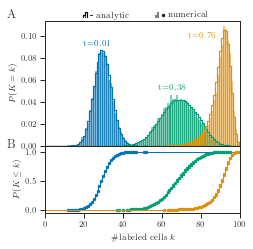

In [22]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(3,figsize=(sizeB, sizeH*1.28))
fig.clear()

sb.set(context="paper",style='ticks',font=font,font_scale=fonts)

ax1 = plt.subplot2grid((3,1),(0,0),rowspan=2)
ax2 = plt.subplot2grid((3,1),(2,0))
ax1.plot(-3,-3,"k-",label="Solution")
ax1.plot(-3,-3,"k.",label="Simulation")

ee=10
ss=4

def cmap(x):
    return sb.color_palette(palette='colorblind',n_colors=3)[int((x*1000)%3)]

norm = mpl.colors.Normalize(vmin=time_points[:-ee:ss][0], vmax=time_points[:-ee:ss][-1])


for i_n,(i,d,p) in enumerate(zip(time_points[:-ee:ss],data_asy[:-ee:ss],pdfs[:-ee:ss])):
    h = ax1.hist(d[0],density=True,bins=np.arange(X[0]-0.5,X[-1]+0.5),color=cmap(norm(i)),alpha=0.5,lw=0 )
    ax1.plot(X,p,color=cmap(norm(i)),drawstyle='steps-mid')
    ax1.bar(X,p,1,linewidth=0.5,color=(0,0,0,0),edgecolor=cmap(norm(i)))
    if i_n==2:
        ax1.annotate("t={:1.2f}".format(i),xy=(np.mean(d[0]),h[0].max()) ,xytext=(np.mean(d[0])-17,h[0].max()-0.01 ),\
                color=cmap(norm(i)))
    else:
        ax1.annotate("t={:1.2f}".format(i),xy=(np.mean(d[0]),h[0].max()) ,xytext=(np.mean(d[0])-10,h[0].max()+0.005 ),\
                color=cmap(norm(i)))
#ax1.legend()
ax1.set_xlim(0,100)
ax1.set_ylim(0,0.114)
  
    
ax2.plot(-3,-3,"k-",label="Solution")
ax2.plot(-3,-3,"k.",label="Simulation")


for i,d,p in zip(time_points[:-ee:ss],data_asy[:-ee:ss],pdfs[:-ee:ss]):

    ax2.plot(X,np.cumsum(p),"-",color=cmap(norm(i)),drawstyle='steps-mid',lw=1 )
    xx,y = clapy.ecdf(d[0])
    ux,cx = np.unique(xx,return_counts=True)
    ax2.plot(ux,[y[k:j].max() for k,j in zip(np.cumsum(cx)-cx[0],np.cumsum(cx))],'.',color=cmap(norm(i)) )
    #ax2.annotate("t={}".format(i),xy=(np.mean(xx),np.mean(y)),xytext=(np.mean(xx)-10,(2-i)*0.3+0.2 ),\
    #            color=cmap(norm(i)),bbox={'facecolor':'white', 'alpha':1, 'pad':2})

#ax2.legend()
ax2.set_xlim(0,100)
ax2.set_ylim(-0.05,1.11)



ax1.set_xticks([])
ax1.set_xlabel('')

ax2.set_xlabel('\#labeled cells $k$')

ax1.set_ylabel('$P(K = k)$')
ax2.set_ylabel('$P(K\leq k)$')

divider = make_axes_locatable(ax1)
lax = divider.append_axes("top", size="5%", pad=0.035)
lax.set_xticks([])
lax.set_yticks([])
lax.set_frame_on(False)
lax.set_xlim(0,100)
a = 20
a3 = 37
s = 1.2
a2 = 2.5*s
at= 6

lax.text(a+at,0,'analytic')
lax.bar(a+s*np.array([0,1]),[2.8,5],s*1,linewidth=0.5,color=(0,0,0,0),edgecolor='black')
lax.plot(a+s*np.array([-0.50,-0.5,0.5,0.5,1.5,1.5]),[0,2.8,2.8,5,5,0],color='black')
lax.plot(a+a2+s*np.array([-0.,1.]),[2.5,2.5],lw=1,color='k')

lax.text(a+a3+at,0,'numerical')
lax.bar(a+a3+s*np.array([0,1]),[2.8,5],s*1,linewidth=0.0,color=(0,0,0,0),edgecolor=None,alpha=0.5)
lax.plot(a+a3+a2+s*np.array([0.5]),[2.5],'k.')


bb = ax1.get_position()
atxt = plt.figtext(bb.x0-0.09,bb.y1+0.04 ,'A',size='x-large',zorder=7)

bb = ax2.get_position()
atxt = plt.figtext(bb.x0-0.09,bb.y1+0.06 ,'B',size='x-large',zorder=7)


plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.savefig("3.pdf")

['/minuit_full_newT_s100_GF095_m5', '/minuit_full_newT_s5_GF095_m5', '/minuit_full_t001_15_s100_GF095_m100', '/minuit_full_t001_15_s5_GF095_m5']
Tc not found
r not found
ss not found
sc not found
GFf not found


/usr/lib64/python3.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/usr/lib64/python3.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


Tc not found
r not found
ss not found
sc not found
GFf not found


/home/julian/brdu/git_final/clapy/clapy.py:308: UserWarning: DataFrame has more than 2 dimension. Average is plotted
  warnings.warn("DataFrame has more than 2 dimension. Average is plotted")
/home/julian/brdu/git_final/clapy/clapy.py:308: UserWarning: DataFrame has more than 2 dimension. Average is plotted
  warnings.warn("DataFrame has more than 2 dimension. Average is plotted")


1.2


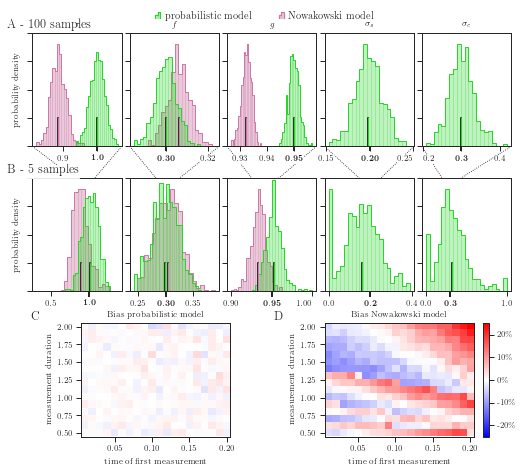

In [9]:
import matplotlib.transforms as plttransforms
import matplotlib.lines as pltlines

ho_abc = 0.35
ho_abc2 = 0.45
alpha_no = 0.4
alpha_pr = 0.3
#load data
with pd.HDFStore("data_minuit_1000") as store:
    print(store.keys())
    data_s = store['minuit_full_t001_15_s5_GF095_m5']
    data_sv = store['minuit_full_t001_15_s100_GF095_m100']
'''
with pd.HDFStore("data2") as store:
    print(store.keys())
    data_sv = store['minuit_full_t001_15_s5_GF095_m5']
    data_sv.index.rename(['model','sPopulation','sSample','N'],inplace=True)
    data_sv['M'] = 5
    data_sv.set_index('M', append=True, inplace=True)
    data_sv['GF'] = 0.95
    data_sv.set_index('GF', append=True, inplace=True)
    data_sv = data_sv.reorder_levels(['model','sPopulation','sSample','M','GF','N'])
    data_sv.rename({'sigma_cell' : 'sc','sigma_cell_error':'sc_error','sigma_sample':'ss','sigma_sample_error':'ss_error'}, axis="columns",inplace=True)
'''
#set dataframe
f = plt.figure(4,figsize=(sizeB*2, sizeH*2.5))
f.clear()

sb.set(context="paper",style='ticks',font=font,font_scale=fonts)
fh = f.get_figheight() 
fb = f.get_figwidth() 

f.subplots_adjust(left=0.06,right=0.99,hspace=0.28,top=0.94)
f.clear()
p = {'Tc' : 1,'r' : 0.3 , 'ss':0.2,'sc' :0.3,'GFf':0.95,'m' : 5 }

A = 'full' 
B = 'old' 
#plot swarm wit N_data points
N_data = 100
#plot and calc
data,sdata = clapy.calc_statistic(data_sv,p)
axs = (3,10)

ax_1 = plt.subplot2grid(axs,(0,0),colspan=2)
ax_2 = plt.subplot2grid(axs,(0,2),colspan=2)
ax_3 = plt.subplot2grid(axs,(0,4),colspan=2)
ax_4 = plt.subplot2grid(axs,(0,6),colspan=2)
ax_5 = plt.subplot2grid(axs,(0,8),colspan=2)

ax_6 = plt.subplot2grid(axs,(1,0),colspan=2)
ax_7 = plt.subplot2grid(axs,(1,2),colspan=2)
ax_8 = plt.subplot2grid(axs,(1,4),colspan=2)
ax_9 = plt.subplot2grid(axs,(1,6),colspan=2)
ax_10 = plt.subplot2grid(axs,(1,8),colspan=2)
        
ax_11 = plt.subplot2grid(axs,(2,1),colspan=4)
ax_12 = plt.subplot2grid(axs,(2,6),colspan=4)

ax_10.set_xticks([0,0.3,1])

types = ['Tc','r','GFf','ss','sc']
axes_0 = [ax_1,ax_2,ax_3,ax_4,ax_5]
axes_1 = [ax_6,ax_7,ax_8,ax_9,ax_10]
names = [r'$\tau$',r'$f$',r'$g$',r'$\sigma_s$',r'$\sigma_c$']


hist = dict()
mhist = dict()
scalef = []
for typ,ax_s in zip(types,axes_0):
        try:
            hist[typ+"o"] = np.histogram(data[typ].loc[idx['old',p['ss'],p['sc'],p['m'],p['GFf']]],density=True)
        except:
            pass
        hist[typ+"f"] = np.histogram(data[typ].loc[idx['full',p['ss'],p['sc'],p['m'],p['GFf']]],density=True)
    
for typ,ax_s in zip(types,axes_0):
        try:
            bins = np.linspace(hist[typ+'o'][1][0],hist[typ+'o'][1][-1],len(hist[typ+'o'][1])*2)
            hist[typ+"o"] = ax_s.hist(data[typ].loc[idx['old',p['ss'],p['sc'],p['m'],p['GFf']]],\
                                      bins=bins,alpha=alpha_no ,density=True,color=color_no,ec=color_no,linewidth=0.5)
            ax_s.hist(data[typ].loc[idx['old',p['ss'],p['sc'],p['m'],p['GFf']]],\
                      bins=bins,density=True,histtype='step',color=color_no,linewidth=1.0)
            mhist[typ+"o"] = hist[typ+"o"][0].max()
        except:
            mhist[typ+"o"] = 0
            pass
        bins = np.linspace(hist[typ+'f'][1][0],hist[typ+'f'][1][-1],len(hist[typ+'f'][1])*2)
        ax_s.hist(data[typ].loc[idx['full',p['ss'],p['sc'],p['m'],p['GFf']]],\
                  bins=bins,density=True,histtype='step',color=color_pr,linewidth=1.0)
        hist[typ+"f"] = ax_s.hist(data[typ].loc[idx['full',p['ss'],p['sc'],p['m'],p['GFf']]],\
                                  bins=bins,alpha=alpha_pr ,density=True,color=color_pr,edgecolor=color_pr,linewidth=0.5)

        mhist[typ+"f"] = hist[typ+"f"][0].max()
        
        scalef.append(mhist[typ+"f"] < mhist[typ+"o"])
        
scalef = np.max( scalef ) 
for typ,ax_s,name in zip(types,axes_0,[r'$\tau$',r'$f$',r'$g$',r'$\sigma_s$',r'$\sigma_c$']):
    if scalef:
        a = 'o'
        b = 'f'
    else:
        a = 'f'
        b = 'o'
    if mhist[typ+a] == 0:
        ax_s.set_ylim(0,mhist[typ+b]*1/0.9)
        ymax = mhist[typ+b]*1/0.9
    else:
        ax_s.set_ylim(0,mhist[typ+a]*1/0.9)
        ymax = mhist[typ+a]*1/0.9
    try:
        xo = np.mean(data[typ].loc[idx['old',p['ss'],p['sc'],p['m'],p['GFf']]])
        ind = np.sum(hist[typ+'o'][1]<xo)-1
        ax_s.plot([xo,xo],[0, ymax*0.249 ],"-",color=color_no,lw=1.2,zorder=1.1)      
        ax_s.plot([xo,xo],[0, ymax*0.25],"-",lw=2,color='.15',zorder=1)
    except:
        pass
    aco = sdata[typ+'_p'].loc[idx['old',p['ss'],p['sc'],p['m'],p['GFf']]]
    acn = sdata[typ+'_p'].loc[idx['full',p['ss'],p['sc'],p['m'],p['GFf']]]
    ax_s.set_title(r'{}'.format(name)  )
    xf = np.mean(data[typ].loc[idx['full',p['ss'],p['sc'],p['m'],p['GFf']]])
    ind = np.sum(hist[typ+'f'][1]<xf)-1
    ax_s.plot([xf,xf],[0, ymax*0.249 ],"-",color=color_pr,lw=1.2,zorder=1.1)      
    ax_s.plot([xf,xf],[0, ymax*0.25 ],"-",color='.15',lw=2,zorder=1)        
    #ax_s.plot([p[typ],p[typ]],[0,ymax*0.2],"-",color='gray',lw=4,zorder=8)
    ax_s.set_yticks(np.linspace(0,1,5)*ymax)
    ax_s.set_yticklabels([])
    
    

 

data,sdata = clapy.calc_statistic(data_s,p)



hist = dict()
mhist = dict()
scalef = []
for typ,ax_s in zip(types,axes_1):
        try:
            hist[typ+"o"] = np.histogram(data[typ].loc[idx['old',p['ss'],p['sc'],p['m'],p['GFf']]],density=True)
        except:
            pass
        hist[typ+"f"] = np.histogram(data[typ].loc[idx['full',p['ss'],p['sc'],p['m'],p['GFf']]],density=True)
    

    
for typ,ax_s in zip(types,axes_1):
        try:
            bins = np.linspace(hist[typ+'o'][1][0],hist[typ+'o'][1][-1],len(hist[typ+'o'][1])*2)
            hist[typ+"o"] = ax_s.hist(data[typ].loc[idx['old',p['ss'],p['sc'],p['m'],p['GFf']]],\
                                      bins=bins,alpha=alpha_no ,density=True,color=color_no,ec=color_no,linewidth=0.5)
            ax_s.hist(data[typ].loc[idx['old',p['ss'],p['sc'],p['m'],p['GFf']]],\
                      bins=bins,density=True,histtype='step',color=color_no,linewidth=1.0)
            mhist[typ+"o"] = hist[typ+"o"][0].max()
        except:
            mhist[typ+"o"] = 0
            pass
        bins = np.linspace(hist[typ+'f'][1][0],hist[typ+'f'][1][-1],len(hist[typ+'f'][1])*2)
        ax_s.hist(data[typ].loc[idx['full',p['ss'],p['sc'],p['m'],p['GFf']]],\
                  bins=bins,density=True,histtype='step',color=color_pr,linewidth=1.0)
        hist[typ+"f"] = ax_s.hist(data[typ].loc[idx['full',p['ss'],p['sc'],p['m'],p['GFf']]],\
                                  bins=bins,alpha=alpha_pr ,density=True,color=color_pr,ec=color_pr,lw=0.5)

        mhist[typ+"f"] = hist[typ+"f"][0].max()
        
        scalef.append([mhist[typ+"f"] < mhist[typ+"o"]])
        
scalef = np.max( scalef )
for typ,ax_s,name in zip(types,axes_1,names):
    if scalef:
        a = 'o'
        b = 'f'
    else:
        a = 'f'
        b = 'o'
    if mhist[typ+a] == 0:
        ax_s.set_ylim(0,mhist[typ+b]*1/0.9)
        ymax = mhist[typ+b]*1/0.9
    else:
        ax_s.set_ylim(0,mhist[typ+a]*1/0.9)
        ymax = mhist[typ+a]*1/0.9
    try:
        xo = np.mean(data[typ].loc[idx['old',p['ss'],p['sc'],p['m'],p['GFf']]])
        ind = np.sum(hist[typ+'o'][1]<xo)-1
        ax_s.plot([xo,xo],[0, ymax*0.249 ],"-",color=color_no,lw=1.2,zorder=1.1)      
        ax_s.plot([xo,xo],[0, ymax*0.25],"-",lw=2,color='.15',zorder=1)
    except:
        pass
    aco = sdata[typ+'_p'].loc[idx['old',p['ss'],p['sc'],p['m'],p['GFf']]]
    acn = sdata[typ+'_p'].loc[idx['full',p['ss'],p['sc'],p['m'],p['GFf']]]
    #ax_s.set_title(r'{}'.format(name)  )
    xf = np.mean(data[typ].loc[idx['full',p['ss'],p['sc'],p['m'],p['GFf']]])
    ind = np.sum(hist[typ+'f'][1]<xf)-1
    ax_s.plot([xf,xf],[0, ymax*0.249 ],"-",color=color_pr,lw=1.2,zorder=1.1)      
    ax_s.plot([xf,xf],[0, ymax*0.25 ],"-",color='.15',lw=2,zorder=1)      
    #ax_s.plot([p[typ],p[typ]],[0,ymax*0.2],"-",color='gray',lw=4,zorder=8)
    ax_s.set_yticks(np.linspace(0,1,5)*ymax)
    ax_s.set_yticklabels([])
    
    

    
            
with pd.HDFStore('paper_ab',complevel=9) as store:
     allimnew = store['s100_n10'].loc[idx[:,:0.2:,:],:].copy()

allimnew.reset_index(inplace=True)
allimnew.rename({"level_0":"model"}, axis="columns",inplace=True)
allimnew.set_index(['model','start','leng','N'],inplace=True)
allimnew.sort_index(inplace=True)

        
im = clapy.plot2d_pandas(allimnew.loc[idx['old']],'Tc','start','leng',aspect='auto',vmin=0.75,vmax=1.25,\
        cmap=plt.cm.bwr,axis=ax_12)

cbar = plt.colorbar(im,ax=ax_12)
tl = cbar.ax.get_yticklabels()
plt.draw()
tl = [float(i.get_text().replace('$','')) for i in tl]

cbar.ax.set_yticklabels(['{:2.0f}'.format( (i-1)*100 )+"\%" for i in tl])

im = clapy.plot2d_pandas(allimnew.loc[idx['full']],'Tc','start','leng',aspect='auto',vmin=0.75,vmax=1.25,\
        cmap=plt.cm.bwr,axis=ax_11)
#plt.colorbar(im,ax=ax_11,extend='neither')

ax_11.set_ylabel('measurement duration')
ax_12.set_ylabel('measurement duration')
ax_11.set_xlabel('time of first measurement')
ax_12.set_xlabel('time of first measurement')

#add lines
for azoom,aall in zip(axes_0,axes_1):
    azoom.set_zorder(10)
    aall.set_zorder(6)
    clapy.zoom_effect02(azoom,aall,color='black',ls=':',zorder=0)

    
#add text
ax_1.set_ylabel('probability density')
bb = ax_1.get_position()
atxt = plt.figtext(bb.x0 - ho_abc/fb,bb.y1 + 0.05/fh,'A - 100 samples',size='x-large',zorder=7)

ax_6.set_ylabel('probability density')
bb = ax_6.get_position()
btxt = plt.figtext(bb.x0 - ho_abc/fb,bb.y1 + 0.05/fh,'B - 5 samples',size='x-large',zorder=7)
btxt.set_bbox(dict(facecolor='white', alpha=1, edgecolor=None,pad=0))



#ax_tmp = plt.subplot2grid(axs,(2,0))
#ax_tmp.set_axis_off()
#bb = ax_tmp.get_position()
#plt.figtext(bb.x0 - ho_abc/fb,bb.y1 + 0.05/fh,'C',size='x-large')

bb = ax_11.get_position()
plt.figtext(bb.x0 - 0.7/fb,bb.y1 + 0.05/fh,'C',size='x-large')
bb = ax_12.get_position()
plt.figtext(bb.x0 - 0.7/fb,bb.y1 + 0.05/fh,'D',size='x-large')

plt.draw()
        
tmp = ax_4.get_xticklabels()
tmp[-2].set_horizontalalignment('right')
ax_4.set_xticklabels(tmp)

tmp = ax_5.get_xticklabels()
tmp[1].set_horizontalalignment('left')
ax_5.set_xticklabels(tmp)

tmp = ax_8.get_xticklabels()
tmp[-2].set_horizontalalignment('right')
ax_8.set_xticklabels(tmp)

for ax_s in axes_0:
    for t in ax_s.get_xticklabels():
        #try:
        #    bbox = t.get_window_extent().transformed(ax_s.transData.inverted())
        #except:
        #    continue
        #rect = mpl.patches.Rectangle((bbox.x0,bbox.y0), bbox.x1 - bbox.x0 ,bbox.y1 - bbox.y0 , ec="none", color='white',zorder=0)
        #rect.set_clip_on(False)
        #ax_s.add_patch(rect)
        t.set_bbox(dict(facecolor='white', alpha=1, edgecolor=None,pad=0))


for typ,ax_s in zip(types,axes_0):
    labels = []
    trans = plttransforms.blended_transform_factory(ax_s.transData, ax_s.transAxes)
    for l,t in zip(ax_s.get_xticklabels(),ax_s.get_xticks()):
        la = l.get_text()
        if np.abs(t - p[typ])<0.005:
            lold = la.replace('$','')
            #lfont = l.get_font_properties()
            #lfont.set_weight('bold')
            #l.set_fontproperties(font)
            la = '$\\mathbf{'+lold+'}$'
            line = pltlines.Line2D([t,t],[0,-0.045],color='0.15',transform=trans,clip_on=False,lw=2,solid_capstyle='butt' )
            ax_s.add_line(line)
        labels.append(la)
    ax_s.set_xticklabels(labels)
        
for typ,ax_s in zip(types,axes_1):
    labels = []
    trans = plttransforms.blended_transform_factory(ax_s.transData, ax_s.transAxes)
    for l,t in zip(ax_s.get_xticklabels(),ax_s.get_xticks()):
        la = l.get_text()
        if np.abs(t - p[typ])<0.005:
            lold = la.replace('$','')
            #lfont = l.get_font_properties()
            #lfont.set_weight('bold')
            #l.set_fontproperties(font)
            la = '$\\mathbf{'+lold+'}$'
            line = pltlines.Line2D([t,t],[0,-0.045],color='0.15',transform=trans,clip_on=False,lw=2,solid_capstyle='butt' )
            ax_s.add_line(line)
        labels.append(la)
    ax_s.set_xticklabels(labels)

bb = ax_2.get_position()
lax = plt.axes([bb.x0 - 0.2/fb,bb.y1 + 0.2/fh ,0.4,0.014])
lax.set_xticks([])
lax.set_yticks([])
lax.set_frame_on(False)
lax.set_xlim(0,100)
a = 20
a3 = 60
s = 1.2
at= 4

lax.text(a+at,0,'probabilistic model',size='large')
lax.bar(a+s*np.array([0,1]),[2.8,5],s*1,linewidth=0.5,color='w',edgecolor=color_pr,alpha=alpha_pr)
lax.plot(a+s*np.array([-0.50,-0.5,0.5,0.5,1.5,1.5]),[0,2.8,2.8,5,5,0],color=color_pr)
lax.bar(a+s*np.array([0,1]),[2.8,5],s*1,linewidth=0.0,color=color_pr,edgecolor=None,alpha=alpha_pr)

lax.text(a3+a+at,0,'Nowakowski model',size='large')
lax.bar(a3+a+s*np.array([0,1]),[2.8,5],s*1,linewidth=0.5,color='w',edgecolor=color_no,alpha=alpha_no)
lax.plot(a3+a+s*np.array([-0.50,-0.5,0.5,0.5,1.5,1.5]),[0,2.8,2.8,5,5,0],color=color_no)
lax.bar(a3+a+s*np.array([0,1]),[2.8,5],s*1,linewidth=0.0,color=color_no,edgecolor=None,alpha=alpha_no)

bb = ax_12.get_position()
ax_11.set_position([ax_11.get_position().x0,bb.y0,bb.width,bb.height])

ax_11.set_title('Bias probabilistic model')
ax_12.set_title('Bias Nowakowski model')


plt.draw()
f.savefig("4.pdf")
print(s)

['/minuit_full_t001_15_s100_GF095_m5', '/minuit_full_t001_15_s5_GF095_m5']
Tc not found
r not found
ss not found
sc not found
GFf not found
Tc not found
r not found
ss not found
sc not found
GFf not found


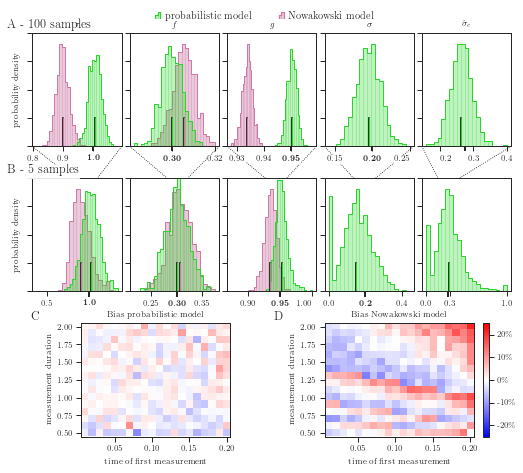

In [24]:
import matplotlib.transforms as plttransforms
import matplotlib.lines as pltlines

ho_abc = 0.35
ho_abc2 = 0.45
alpha_no = 0.4
alpha_pr = 0.3
#load data
'''
with pd.HDFStore("data_minuit_1000") as store:
    print(store.keys())
    data_s = store['minuit_full_t001_15_s5_GF095_m5']
    data_sv = store['minuit_full_t001_15_s100_GF095_m100']
'''
with pd.HDFStore("data_new") as store:
    print(store.keys())
    data_sv = store['minuit_full_t001_15_s100_GF095_m5']
    data_sv.index.rename(['model','sPopulation','sSample','N'],inplace=True)
    data_sv['M'] = 5
    data_sv.set_index('M', append=True, inplace=True)
    data_sv['GF'] = 0.95
    data_sv.set_index('GF', append=True, inplace=True)
    data_sv = data_sv.reorder_levels(['model','sPopulation','sSample','M','GF','N'])
    data_sv.rename({'sigma_cell' : 'sc','sigma_cell_error':'sc_error','sigma_sample':'ss','sigma_sample_error':'ss_error'}, axis="columns",inplace=True)

    data_s = store['minuit_full_t001_15_s5_GF095_m5']
    data_s.index.rename(['model','sPopulation','sSample','N'],inplace=True)
    data_s['M'] = 5
    data_s.set_index('M', append=True, inplace=True)
    data_s['GF'] = 0.95
    data_s.set_index('GF', append=True, inplace=True)
    data_s = data_s.reorder_levels(['model','sPopulation','sSample','M','GF','N'])
    data_s.rename({'sigma_cell' : 'sc','sigma_cell_error':'sc_error','sigma_sample':'ss','sigma_sample_error':'ss_error'}, axis="columns",inplace=True)

#set dataframe
f = plt.figure(4,figsize=(sizeB*2, sizeH*2.5))
f.clear()

sb.set(context="paper",style='ticks',font=font,font_scale=fonts)
fh = f.get_figheight() 
fb = f.get_figwidth() 

f.subplots_adjust(left=0.06,right=0.99,hspace=0.28,top=0.94)
f.clear()
p = {'Tc' : 1,'r' : 0.3 , 'ss':0.2,'sc' :0.3,'GFf':0.95,'m' : 5 }

A = 'full' 
B = 'old' 
#plot swarm wit N_data points
N_data = 100
#plot and calc
data,sdata = clapy.calc_statistic(data_sv,p)
axs = (3,10)

ax_1 = plt.subplot2grid(axs,(0,0),colspan=2)
ax_2 = plt.subplot2grid(axs,(0,2),colspan=2)
ax_3 = plt.subplot2grid(axs,(0,4),colspan=2)
ax_4 = plt.subplot2grid(axs,(0,6),colspan=2)
ax_5 = plt.subplot2grid(axs,(0,8),colspan=2)

ax_6 = plt.subplot2grid(axs,(1,0),colspan=2)
ax_7 = plt.subplot2grid(axs,(1,2),colspan=2)
ax_8 = plt.subplot2grid(axs,(1,4),colspan=2)
ax_9 = plt.subplot2grid(axs,(1,6),colspan=2)
ax_10 = plt.subplot2grid(axs,(1,8),colspan=2)
        
ax_11 = plt.subplot2grid(axs,(2,1),colspan=4)
ax_12 = plt.subplot2grid(axs,(2,6),colspan=4)

ax_10.set_xticks([0,0.3,1])

types = ['Tc','r','GFf','ss','sc']
axes_0 = [ax_1,ax_2,ax_3,ax_4,ax_5]
axes_1 = [ax_6,ax_7,ax_8,ax_9,ax_10]
names = [r'$\tau$',r'$f$',r'$g$',r'$\sigma$',r'$\hat{\sigma}_c$']


hist = dict()
mhist = dict()
scalef = []
for typ,ax_s in zip(types,axes_0):
        try:
            hist[typ+"o"] = np.histogram(data[typ].loc[idx['old',p['ss'],p['sc'],p['m'],p['GFf']]],density=True)
        except:
            pass
        hist[typ+"f"] = np.histogram(data[typ].loc[idx['full',p['ss'],p['sc'],p['m'],p['GFf']]],density=True)
    
for typ,ax_s in zip(types,axes_0):
        try:
            bins = np.linspace(hist[typ+'o'][1][0],hist[typ+'o'][1][-1],len(hist[typ+'o'][1])*2)
            hist[typ+"o"] = ax_s.hist(data[typ].loc[idx['old',p['ss'],p['sc'],p['m'],p['GFf']]],\
                                      bins=bins,alpha=alpha_no ,density=True,color=color_no,ec=color_no,linewidth=0.5)
            ax_s.hist(data[typ].loc[idx['old',p['ss'],p['sc'],p['m'],p['GFf']]],\
                      bins=bins,density=True,histtype='step',color=color_no,linewidth=1.0)
            mhist[typ+"o"] = hist[typ+"o"][0].max()
        except:
            mhist[typ+"o"] = 0
            pass
        bins = np.linspace(hist[typ+'f'][1][0],hist[typ+'f'][1][-1],len(hist[typ+'f'][1])*2)
        ax_s.hist(data[typ].loc[idx['full',p['ss'],p['sc'],p['m'],p['GFf']]],\
                  bins=bins,density=True,histtype='step',color=color_pr,linewidth=1.0)
        hist[typ+"f"] = ax_s.hist(data[typ].loc[idx['full',p['ss'],p['sc'],p['m'],p['GFf']]],\
                                  bins=bins,alpha=alpha_pr ,density=True,color=color_pr,edgecolor=color_pr,linewidth=0.5)

        mhist[typ+"f"] = hist[typ+"f"][0].max()
        
        scalef.append(mhist[typ+"f"] < mhist[typ+"o"])
        
scalef = np.max( scalef ) 
for typ,ax_s,name in zip(types,axes_0,names):
    if scalef:
        a = 'o'
        b = 'f'
    else:
        a = 'f'
        b = 'o'
    if mhist[typ+a] == 0:
        ax_s.set_ylim(0,mhist[typ+b]*1/0.9)
        ymax = mhist[typ+b]*1/0.9
    else:
        ax_s.set_ylim(0,mhist[typ+a]*1/0.9)
        ymax = mhist[typ+a]*1/0.9
    try:
        xo = np.mean(data[typ].loc[idx['old',p['ss'],p['sc'],p['m'],p['GFf']]])
        ind = np.sum(hist[typ+'o'][1]<xo)-1
        ax_s.plot([xo,xo],[0, ymax*0.249 ],"-",color=color_no,lw=1.2,zorder=1.1)      
        ax_s.plot([xo,xo],[0, ymax*0.25],"-",lw=2,color='.15',zorder=1)
    except:
        pass
    aco = sdata[typ+'_p'].loc[idx['old',p['ss'],p['sc'],p['m'],p['GFf']]]
    acn = sdata[typ+'_p'].loc[idx['full',p['ss'],p['sc'],p['m'],p['GFf']]]
    ax_s.set_title(r'{}'.format(name)  )
    xf = np.mean(data[typ].loc[idx['full',p['ss'],p['sc'],p['m'],p['GFf']]])
    ind = np.sum(hist[typ+'f'][1]<xf)-1
    ax_s.plot([xf,xf],[0, ymax*0.249 ],"-",color=color_pr,lw=1.2,zorder=1.1)      
    ax_s.plot([xf,xf],[0, ymax*0.25 ],"-",color='.15',lw=2,zorder=1)        
    #ax_s.plot([p[typ],p[typ]],[0,ymax*0.2],"-",color='gray',lw=4,zorder=8)
    ax_s.set_yticks(np.linspace(0,1,5)*ymax)
    ax_s.set_yticklabels([])
    
    

 

data,sdata = clapy.calc_statistic(data_s,p)



hist = dict()
mhist = dict()
scalef = []
for typ,ax_s in zip(types,axes_1):
        try:
            hist[typ+"o"] = np.histogram(data[typ].loc[idx['old',p['ss'],p['sc'],p['m'],p['GFf']]],density=True)
        except:
            pass
        hist[typ+"f"] = np.histogram(data[typ].loc[idx['full',p['ss'],p['sc'],p['m'],p['GFf']]],density=True)
    

    
for typ,ax_s in zip(types,axes_1):
        try:
            bins = np.linspace(hist[typ+'o'][1][0],hist[typ+'o'][1][-1],len(hist[typ+'o'][1])*2)
            hist[typ+"o"] = ax_s.hist(data[typ].loc[idx['old',p['ss'],p['sc'],p['m'],p['GFf']]],\
                                      bins=bins,alpha=alpha_no ,density=True,color=color_no,ec=color_no,linewidth=0.5)
            ax_s.hist(data[typ].loc[idx['old',p['ss'],p['sc'],p['m'],p['GFf']]],\
                      bins=bins,density=True,histtype='step',color=color_no,linewidth=1.0)
            mhist[typ+"o"] = hist[typ+"o"][0].max()
        except:
            mhist[typ+"o"] = 0
            pass
        bins = np.linspace(hist[typ+'f'][1][0],hist[typ+'f'][1][-1],len(hist[typ+'f'][1])*2)
        ax_s.hist(data[typ].loc[idx['full',p['ss'],p['sc'],p['m'],p['GFf']]],\
                  bins=bins,density=True,histtype='step',color=color_pr,linewidth=1.0)
        hist[typ+"f"] = ax_s.hist(data[typ].loc[idx['full',p['ss'],p['sc'],p['m'],p['GFf']]],\
                                  bins=bins,alpha=alpha_pr ,density=True,color=color_pr,ec=color_pr,lw=0.5)

        mhist[typ+"f"] = hist[typ+"f"][0].max()
        
        scalef.append([mhist[typ+"f"] < mhist[typ+"o"]])
        
scalef = np.max( scalef )
for typ,ax_s,name in zip(types,axes_1,names):
    if scalef:
        a = 'o'
        b = 'f'
    else:
        a = 'f'
        b = 'o'
    if mhist[typ+a] == 0:
        ax_s.set_ylim(0,mhist[typ+b]*1/0.9)
        ymax = mhist[typ+b]*1/0.9
    else:
        ax_s.set_ylim(0,mhist[typ+a]*1/0.9)
        ymax = mhist[typ+a]*1/0.9
    try:
        xo = np.mean(data[typ].loc[idx['old',p['ss'],p['sc'],p['m'],p['GFf']]])
        ind = np.sum(hist[typ+'o'][1]<xo)-1
        ax_s.plot([xo,xo],[0, ymax*0.249 ],"-",color=color_no,lw=1.2,zorder=1.1)      
        ax_s.plot([xo,xo],[0, ymax*0.25],"-",lw=2,color='.15',zorder=1)
    except:
        pass
    aco = sdata[typ+'_p'].loc[idx['old',p['ss'],p['sc'],p['m'],p['GFf']]]
    acn = sdata[typ+'_p'].loc[idx['full',p['ss'],p['sc'],p['m'],p['GFf']]]
    #ax_s.set_title(r'{}'.format(name)  )
    xf = np.mean(data[typ].loc[idx['full',p['ss'],p['sc'],p['m'],p['GFf']]])
    ind = np.sum(hist[typ+'f'][1]<xf)-1
    ax_s.plot([xf,xf],[0, ymax*0.249 ],"-",color=color_pr,lw=1.2,zorder=1.1)      
    ax_s.plot([xf,xf],[0, ymax*0.25 ],"-",color='.15',lw=2,zorder=1)      
    #ax_s.plot([p[typ],p[typ]],[0,ymax*0.2],"-",color='gray',lw=4,zorder=8)
    ax_s.set_yticks(np.linspace(0,1,5)*ymax)
    ax_s.set_yticklabels([])
    
    

    
            
with pd.HDFStore('paper_ab_new',complevel=9) as store:
     allimnew = store['s100_n10'].loc[idx[:,:0.2:,:],:].copy()

allimnew.reset_index(inplace=True)
allimnew.rename({"level_0":"model"}, axis="columns",inplace=True)
allimnew.set_index(['model','start','leng','N'],inplace=True)
allimnew.sort_index(inplace=True)

        
im = clapy.plot2d_pandas(allimnew.loc[idx['old']],'Tc','start','leng',aspect='auto',vmin=0.75,vmax=1.25,\
        cmap=plt.cm.bwr,axis=ax_12)

cbar = plt.colorbar(im,ax=ax_12)
tl = cbar.ax.get_yticklabels()
plt.draw()
tl = [float(i.get_text().replace('$','')) for i in tl]

cbar.ax.set_yticklabels(['{:2.0f}'.format( (i-1)*100 )+"\%" for i in tl])

im = clapy.plot2d_pandas(allimnew.loc[idx['full']],'Tc','start','leng',aspect='auto',vmin=0.75,vmax=1.25,\
        cmap=plt.cm.bwr,axis=ax_11)
#plt.colorbar(im,ax=ax_11,extend='neither')

ax_11.set_ylabel('measurement duration')
ax_12.set_ylabel('measurement duration')
ax_11.set_xlabel('time of first measurement')
ax_12.set_xlabel('time of first measurement')

#add lines
for azoom,aall in zip(axes_0,axes_1):
    azoom.set_zorder(10)
    aall.set_zorder(6)
    clapy.zoom_effect02(azoom,aall,color='black',ls=':',zorder=0)

    
#add text
ax_1.set_ylabel('probability density')
bb = ax_1.get_position()
atxt = plt.figtext(bb.x0 - ho_abc/fb,bb.y1 + 0.05/fh,'A - 100 samples',size='x-large',zorder=7)

ax_6.set_ylabel('probability density')
bb = ax_6.get_position()
btxt = plt.figtext(bb.x0 - ho_abc/fb,bb.y1 + 0.05/fh,'B - 5 samples',size='x-large',zorder=7)
btxt.set_bbox(dict(facecolor='white', alpha=1, edgecolor=None,pad=0))



#ax_tmp = plt.subplot2grid(axs,(2,0))
#ax_tmp.set_axis_off()
#bb = ax_tmp.get_position()
#plt.figtext(bb.x0 - ho_abc/fb,bb.y1 + 0.05/fh,'C',size='x-large')

bb = ax_11.get_position()
plt.figtext(bb.x0 - 0.7/fb,bb.y1 + 0.05/fh,'C',size='x-large')
bb = ax_12.get_position()
plt.figtext(bb.x0 - 0.7/fb,bb.y1 + 0.05/fh,'D',size='x-large')

plt.draw()
        
tmp = ax_4.get_xticklabels()
tmp[-2].set_horizontalalignment('right')
ax_4.set_xticklabels(tmp)

tmp = ax_5.get_xticklabels()
tmp[1].set_horizontalalignment('left')
ax_5.set_xticklabels(tmp)

tmp = ax_8.get_xticklabels()
tmp[-2].set_horizontalalignment('right')
ax_8.set_xticklabels(tmp)

for ax_s in axes_0:
    for t in ax_s.get_xticklabels():
        #try:
        #    bbox = t.get_window_extent().transformed(ax_s.transData.inverted())
        #except:
        #    continue
        #rect = mpl.patches.Rectangle((bbox.x0,bbox.y0), bbox.x1 - bbox.x0 ,bbox.y1 - bbox.y0 , ec="none", color='white',zorder=0)
        #rect.set_clip_on(False)
        #ax_s.add_patch(rect)
        t.set_bbox(dict(facecolor='white', alpha=1, edgecolor=None,pad=0))


for typ,ax_s in zip(types,axes_0):
    labels = []
    trans = plttransforms.blended_transform_factory(ax_s.transData, ax_s.transAxes)
    for l,t in zip(ax_s.get_xticklabels(),ax_s.get_xticks()):
        la = l.get_text()
        if np.abs(t - p[typ])<0.005 and typ!='sc':
            lold = la.replace('$','')
            #lfont = l.get_font_properties()
            #lfont.set_weight('bold')
            #l.set_fontproperties(font)
            la = '$\\mathbf{'+lold+'}$'
            line = pltlines.Line2D([t,t],[0,-0.045],color='0.15',transform=trans,clip_on=False,lw=2,solid_capstyle='butt' )
            ax_s.add_line(line)
        labels.append(la)
    ax_s.set_xticklabels(labels)  
    
for typ,ax_s in zip(types,axes_1):
    labels = []
    trans = plttransforms.blended_transform_factory(ax_s.transData, ax_s.transAxes)
    for l,t in zip(ax_s.get_xticklabels(),ax_s.get_xticks()):
        la = l.get_text()
        if np.abs(t - p[typ])<0.005 and typ!='sc':
            lold = la.replace('$','')
            #lfont = l.get_font_properties()
            #lfont.set_weight('bold')
            #l.set_fontproperties(font)
            la = '$\\mathbf{'+lold+'}$'
            line = pltlines.Line2D([t,t],[0,-0.045],color='0.15',transform=trans,clip_on=False,lw=2,solid_capstyle='butt' )
            ax_s.add_line(line)
        labels.append(la)
    ax_s.set_xticklabels(labels)

ax_s = axes_0[-1]
trans = plttransforms.blended_transform_factory(ax_s.transData, ax_s.transAxes)
found=False
for l,t in zip(ax_s.get_xticklabels(),ax_s.get_xticks()):
    la = l.get_text()
    if np.abs(t - clapy.calc_sigma_true(p[typ],0.5,0.2))<0.005:
        lold = la.replace('$','')
        #lfont = l.get_font_properties()
        #lfont.set_weight('bold')
        #l.set_fontproperties(font)
        la = '$\\mathbf{'+lold+'}$'
        line = pltlines.Line2D([t,t],[0,-0.045],color='0.15',transform=trans,clip_on=False,lw=2,solid_capstyle='butt' )
        ax_s.add_line(line)
        found=True
    labels.append(la)
nt = clapy.calc_sigma_true(p[typ],0.5,0.2)
if not found:
    line = pltlines.Line2D([nt,nt],[0,-0.045],color='0.15',transform=trans,clip_on=False,lw=2,solid_capstyle='butt' )
    ax_s.add_line(line)

ax_s = axes_1[-1]
trans = plttransforms.blended_transform_factory(ax_s.transData, ax_s.transAxes)
found=False
for l,t in zip(ax_s.get_xticklabels(),ax_s.get_xticks()):
    la = l.get_text()
    if np.abs(t - clapy.calc_sigma_true(p[typ],0.5,0.2))<0.005:
        lold = la.replace('$','')
        #lfont = l.get_font_properties()
        #lfont.set_weight('bold')
        #l.set_fontproperties(font)
        la = '$\\mathbf{'+lold+'}$'
        line = pltlines.Line2D([t,t],[0,-0.045],color='0.15',transform=trans,clip_on=False,lw=2,solid_capstyle='butt' )
        ax_s.add_line(line)
        found=True
    labels.append(la)
nt = clapy.calc_sigma_true(p[typ],0.5,0.2)
if not found:
    line = pltlines.Line2D([nt,nt],[0,-0.045],color='0.15',transform=trans,clip_on=False,lw=2,solid_capstyle='butt' )
    ax_s.add_line(line)    
    
    
bb = ax_2.get_position()
lax = plt.axes([bb.x0 - 0.2/fb,bb.y1 + 0.2/fh ,0.4,0.014])
lax.set_xticks([])
lax.set_yticks([])
lax.set_frame_on(False)
lax.set_xlim(0,100)
a = 20
a3 = 60
s = 1.2
at= 4

lax.text(a+at,0,'probabilistic model',size='large')
lax.bar(a+s*np.array([0,1]),[2.8,5],s*1,linewidth=0.5,color='w',edgecolor=color_pr,alpha=alpha_pr)
lax.plot(a+s*np.array([-0.50,-0.5,0.5,0.5,1.5,1.5]),[0,2.8,2.8,5,5,0],color=color_pr)
lax.bar(a+s*np.array([0,1]),[2.8,5],s*1,linewidth=0.0,color=color_pr,edgecolor=None,alpha=alpha_pr)

lax.text(a3+a+at,0,'Nowakowski model',size='large')
lax.bar(a3+a+s*np.array([0,1]),[2.8,5],s*1,linewidth=0.5,color='w',edgecolor=color_no,alpha=alpha_no)
lax.plot(a3+a+s*np.array([-0.50,-0.5,0.5,0.5,1.5,1.5]),[0,2.8,2.8,5,5,0],color=color_no)
lax.bar(a3+a+s*np.array([0,1]),[2.8,5],s*1,linewidth=0.0,color=color_no,edgecolor=None,alpha=alpha_no)

bb = ax_12.get_position()
ax_11.set_position([ax_11.get_position().x0,bb.y0,bb.width,bb.height])

ax_11.set_title('Bias probabilistic model')
ax_12.set_title('Bias Nowakowski model')


plt.draw()
f.savefig("4b.pdf")

In [43]:

allimnew.loc[idx['old']].Tc.max()

1.2170413731506882

In [41]:
(b.T).sort_index()

model,full,old
sPopulation,0.2,0.2
sSample,0.3,0.3
M,5,5
GF,0.95,0.95
GFf,0.950288,0.933820
GFf_2std,0.003694,0.006194
GFf_d,0.000288,-0.016180
GFf_error,0.001847,0.003097
GFf_mse,0.049746,0.066207
GFf_p,0.957000,0.000000


In [126]:
m,s=clapy.dist.log_params(None,1,0.3)
mc,sc=clapy.dist.log_params(None,1,clapy.calc_sigma_true(0.3,dargs['G1'],dargs['G2M']))
tchc  = np.random.lognormal(mean=mc,sigma=sc,size=1000000)
tc  = np.random.lognormal(mean=m,sigma=s,size=1000000)
tcd = np.random.lognormal(mean=m,sigma=s,size=1000000)
age = np.random.uniform(size=1000000)
w =np.where(age < dargs['G1']+dargs['S'],dargs['G1']*tc-age*tc,dargs['G1']*tcd+tc-age*tc )
whc=(dargs['G1']+dargs['G2M']-age)*tchc
x,y = clapy.ecdf(w)
xhc,yhc = clapy.ecdf(whc)


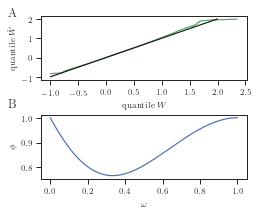

In [163]:
fig = plt.figure(3,figsize=(sizeB, sizeH))
fig.clear()

sb.set(context="paper",style='ticks',font=font,font_scale=fonts)

ax1 = plt.subplot2grid((2,1),(0,0))
plt.plot(x,xhc,'-g')
plt.plot([-1,2],[-1,2],'-k')
ax2 = plt.subplot2grid((2,1),(1,0))
w=np.linspace(0,1,1000)
g1 = w*(1-dargs['S'])
g2m = (1-w)*(1-dargs['S'])
s = clapy.calc_sigma_true(1,g1,g2m)
ax2.plot(w,s)
plt.tight_layout()

ax1.set_xlabel("quantile $W$")
ax1.set_ylabel("quantile $\hat{W}$")

ax2.set_ylabel(r"$\phi$")
ax2.set_xlabel(r"$\omega$")

bb = ax1.get_position()
atxt = plt.figtext(bb.x0-0.09,bb.y1+0.02 ,'A',size='x-large',zorder=7)

bb = ax2.get_position()
atxt = plt.figtext(bb.x0-0.09,bb.y1+0.04 ,'B',size='x-large',zorder=7)
fig.subplots_adjust(left=0.15,right=0.95,hspace=0.55,top=0.95)

fig.savefig("qq.pdf")

(array([1.63333660e-05, 8.16668300e-05, 3.26667320e-05, 1.96000392e-04,
        2.28667124e-04, 1.14333562e-03, 2.49900500e-03, 8.67301735e-03,
        2.45490491e-02, 6.66401333e-02, 1.68789004e-01, 3.87868442e-01,
        7.11693757e-01, 9.91222982e-01, 1.09093818e+00, 1.09263685e+00,
        1.09750420e+00, 1.08564617e+00, 1.09059518e+00, 1.08309817e+00,
        1.07065214e+00, 1.02763006e+00, 9.82206964e-01, 9.25873185e-01,
        8.47897696e-01, 7.34527802e-01, 5.93995521e-01, 4.42127884e-01,
        3.05776945e-01, 2.01112736e-01, 1.21961244e-01, 7.50028167e-02,
        4.29240858e-02, 2.51043835e-02, 1.50593635e-02, 7.57868182e-03,
        4.36100872e-03, 2.45000490e-03, 1.50266967e-03, 7.84001568e-04,
        1.79667026e-04, 3.10333954e-04, 9.80001960e-05, 4.90000980e-05,
        8.16668300e-05, 0.00000000e+00, 3.26667320e-05, 0.00000000e+00,
        0.00000000e+00]),
 array([-1.        , -0.93877551, -0.87755102, -0.81632653, -0.75510204,
        -0.69387755, -0.63265306, -0.

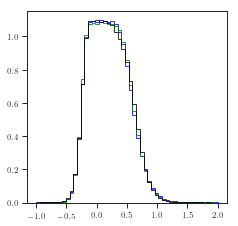

In [123]:
fig = plt.figure(3,figsize=(sizeB, sizeH*1.28))
fig.clear()

sb.set(context="paper",style='ticks',font=font,font_scale=fonts)

ax1 = plt.subplot2grid((1,1),(0,0))
bins = np.linspace(-1,2,50)
c=False
plt.hist(xh,bins=bins,density=True,alpha=1,histtype="step",color='blue',cumulative=c)
plt.hist(xhc,bins=bins,density=True,alpha=1,histtype="step",color='green',cumulative=c)
plt.hist(x,bins=bins,density=True,alpha=1,histtype="step",color='black',cumulative=c)
